### Setup

apt install requirements

In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

zsh:1: command not found: apt-get
zsh:1: command not found: apt-get


In [10]:
import os
print(os.getcwd())

/Users/samueloliveira/Documents/Masters/Project/diffuser_irl/diffuser
/Users/samueloliveira/Documents/Masters/Project/diffuser_irl


Clone repo and install dependencies

In [3]:
pip install -e .

Obtaining file:///Users/samueloliveira/Documents/Masters/Project/diffuser_irl
  Preparing metadata (setup.py) ... done
  Attempting uninstall: diffuser
    Found existing installation: diffuser 0.0.0
    Uninstalling diffuser-0.0.0:
      Successfully uninstalled diffuser-0.0.0
  Running setup.py develop for diffuser
Note: you may need to restart the kernel to use updated packages.


In [1]:
%cd /content

## TODO: use when repo is public
# !git clone https://github.com/jannerm/diffuser.git
## backup for private repo
!curl -L -o diffuser.zip https://www.dropbox.com/s/fe1scd8m2jf7zvj/diffuser.tar?dl=1
!tar -xf diffuser.zip
## /TODO

%cd diffuser
%pip install -f https://download.pytorch.org/whl/torch_stable.html \
                typed-argument-parser \
                scikit-image==0.17.2 \
                scikit-video==1.1.11 \
                gitpython \
                einops \
                pillow \
                free-mujoco-py \
                gym \
                git+https://github.com/JannerM/d4rl.git@0e84a4d29db3ae501043215ce1d91843929f1949 \
                git+https://github.com/aravindr93/mjrl

%pip install -e .

[Errno 2] No such file or directory: '/content'
/Users/samueloliveira/Documents/Masters/Project/diffuser_irl
zsh:1: no matches found: https://www.dropbox.com/s/fe1scd8m2jf7zvj/diffuser.tar?dl=1
tar: Error opening archive: Failed to open 'diffuser.zip'
/Users/samueloliveira/Documents/Masters/Project/diffuser_irl/diffuser
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/JannerM/d4rl.git (to revision 0e84a4d29db3ae501043215ce1d91843929f1949) to /private/var/folders/yt/hm1pk9_s67qg0y7c5vfxv6sm0000gn/T/pip-req-build-sqyn8sa6
  Running command git clone --filter=blob:none --quiet https://github.com/JannerM/d4rl.git /private/var/folders/yt/hm1pk9_s67qg0y7c5vfxv6sm0000gn/T/pip-req-build-sqyn8sa6
  Running command git rev-parse -q --verify 'sha^0e84a4d29db3ae501043215ce1d91843929f1949'
  Running command git fetch -q https://github.com/JannerM/d4rl.git 0e84a4d29db3ae501043215ce1d91843929f1949
  Running command git checkout -q 0e84a4d29db3ae5010432

In [1]:
## cythonize mujoco-py at first import
import diffuser.utils as utils

# import importlib
# importlib.reload(utils.colab)

/Users/samueloliveira/opt/anaconda3/envs/diffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Feb 26 2024 16:22:04


### Conditional sampling

In [2]:
class Args:
  loadpath = 'logs/maze2d-large-v1/diffusion/H384_T256'
  diffusion_epoch = 'latest'
  n_samples = 4
  device = 'cpu'
    
args = Args()

Load diffusion model from disk

In [3]:
#%cd /content/diffuser

diffusion_experiment = utils.load_diffusion(
    args.loadpath, epoch=args.diffusion_epoch)

dataset = diffusion_experiment.dataset
renderer = diffusion_experiment.renderer
model = diffusion_experiment.trainer.ema_model

[ utils/serialization ] Loaded config from logs/maze2d-large-v1/diffusion/H384_T256/dataset_config.pkl

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: maze2d-large-v1
    horizon: 384
    max_path_length: 40000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/serialization ] Loaded config from logs/maze2d-large-v1/diffusion/H384_T256/render_config.pkl

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: maze2d-large-v1



ModuleNotFoundError: No module named 'gpytorch'

Initialize environment

In [4]:
import numpy as np
env = dataset.env
env.seed=17
obs = env.reset()
observation=env.set_state(np.asarray([1.2,1.2]),np.asarray([0,0]))
env.set_target(np.asarray([8,12]))

NameError: name 'dataset' is not defined

Run reverse diffusion

In [74]:
observations = utils.colab.run_diffusion(
    model, dataset, obs, args.n_samples, args.device)
print(observations.shape)

(4, 257, 384, 6)
(257, 4, 384, 4)


Render the samples

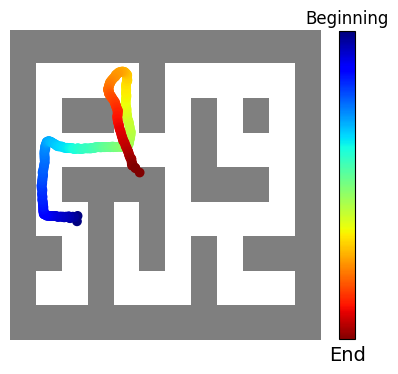

In [76]:
sample = observations[-1]
utils.colab.show_sample(renderer, sample)

Render the full reverse diffusion process for the first sample.

This renders `horizon * n_diffusion_steps` images, so takes a few minutes. Increasing `substep` will speed up the video generation, but cause it to skip frames.

In [5]:
print(observations.shape)
import torch
from os.path import join
import numpy as np
ranges=[0,200,230,250,254,256]
array=torch.flatten(torch.from_numpy(observations[ranges,3:4,:,:]),start_dim=1,end_dim=1)
#array=[array[i,:,:] for i in range(array.shape[0])]
#print(len(array))
#print(array[0].shape)
#renderer.composite(join('logs/','rollout.png'),np.array(array),n_cols=1)

for i in range(array.shape[0]):
    #curr_array=[array[i,0,j].detach().cpu().numpy().copy() for j in range(array.shape[2])]
    curr_array=[array[i,0,j].detach().cpu().numpy().copy() for j in range(290)]
    for step in range(0,10):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.5)
        elif i==3:
            noise=np.random.normal(0,0.15)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.001)
        curr_array.append(torch.Tensor([0.9+step*0.02+noise,3.5-step*0.07+noise,0,0]).detach().cpu().numpy())
    
    for step in range(0,10):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.5)
        elif i==3:
            noise=np.random.normal(0,0.15)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.001)
        curr_array.append(torch.Tensor([1.1+step*0.001+noise,2.8-step*0.1+noise,0,0]).detach().cpu().numpy())
   
    #print(len(curr_array))
    #print(curr_array[0].shape)
    #print(np.array(curr_array)[None].shape)
    curr_array=np.array(curr_array)[None]
    #curr_array=[curr_array[i,:,:].copy() for i in range(curr_array.shape[0])]
    print(len(curr_array))
    renderer.composite(join('logs/','rollout_2_{step}.png'.format(step=ranges[i])),curr_array,ncol=1)
#utils.colab.show_diffusion(renderer, observations[:,:1], substep=1)

NameError: name 'observations' is not defined

(257, 4, 384, 4)
1
(393, 4)
1
Saved 1 samples to: logs/rollout_1_0.png
1
(393, 4)
1
Saved 1 samples to: logs/rollout_1_200.png
1
(393, 4)
1
Saved 1 samples to: logs/rollout_1_230.png
1
(393, 4)
1
Saved 1 samples to: logs/rollout_1_250.png
1
(393, 4)
1
Saved 1 samples to: logs/rollout_1_254.png
1
(393, 4)
1
Saved 1 samples to: logs/rollout_1_256.png


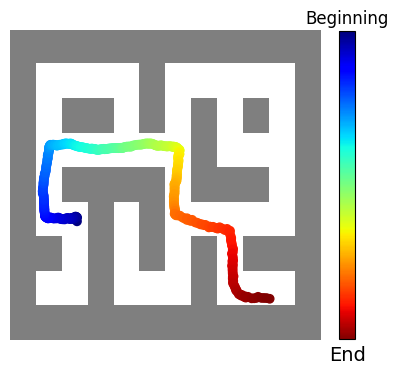

In [148]:
print(observations.shape)
import torch
from os.path import join
import numpy as np
ranges=[0,200,230,250,254,256]
array=torch.flatten(torch.from_numpy(observations[ranges,:1,:,:]),start_dim=1,end_dim=1)
#array=[array[i,:,:] for i in range(array.shape[0])]
#print(len(array))
#print(array[0].shape)
#renderer.composite(join('logs/','rollout.png'),np.array(array),n_cols=1)

for i in range(array.shape[0]):
    #curr_array=[array[i,0,j].detach().cpu().numpy().copy() for j in range(array.shape[2])]
    curr_array=[array[i,0,j].detach().cpu().numpy().copy() for j in range(310)]
    for step in range(0,15):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.5)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([4.85+step*0.02+noise,5.9+step*0.07+noise,0,0]).detach().cpu().numpy())
    for step in range(15,30):
        #noise=np.random.normal(0,0.1) # for 254
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.5)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([5+step*0.01+noise,5.9+step*0.07+noise,0,0]).detach().cpu().numpy())
    for step in range(0,10):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.5)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([5.3+step*0.05+noise,8+step*0.01+noise,0,0]).detach().cpu().numpy())
    for step in range(0,20):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.5)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([5.8+step*0.05+noise,8.1+step*0.001+noise,0,0]).detach().cpu().numpy())
    for step in range(0,5):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.5)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([6.8+step*0.05+noise,8.11+step*0.03+noise,0,0]).detach().cpu().numpy())
    for step in range(0,3):
        if i==0:
            noise=np.random.normal(0,2)
        elif i==1:
            noise=np.random.normal(0,1)
        elif i==2:
            noise=np.random.normal(0,0.3)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([7.05+step*0.04+noise,8.26+step*0.04+noise,0,0]).detach().cpu().numpy())
    for step in range(0,5):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.3)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([7.17+step*0.01+noise,8.38+step*0.05+noise,0,0]).detach().cpu().numpy())
    for step in range(0,10):
        if i==0:
            noise=np.random.normal(0,1)
        elif i==1:
            noise=np.random.normal(0,0.7)
        elif i==2:
            noise=np.random.normal(0,0.3)
        elif i==3:
            noise=np.random.normal(0,0.3)
        elif i==4:
            noise=np.random.normal(0,0.1)
        elif i==5:
            noise=np.random.normal(0,0.02)
        curr_array.append(torch.Tensor([7.25+step*0.002+noise,8.63+step*0.1+noise,0,0]).detach().cpu().numpy())
    #print(len(curr_array))
    #print(curr_array[0].shape)
    #print(np.array(curr_array)[None].shape)
    curr_array=np.array(curr_array)[None]
    #curr_array=[curr_array[i,:,:].copy() for i in range(curr_array.shape[0])]
    print(len(curr_array))
    renderer.composite(join('logs/','rollout_1_{step}.png'.format(step=ranges[i])),curr_array,ncol=1)
#utils.colab.show_diffusion(renderer, observations[:,:1], substep=1)